## - 개요

화장품 전성분$^{1}$ 데이터를 수집하기 위한 사전 작업 중 하나.
<br>
대한화장품협회의 성분사전에서 표준화된 모든 화장품 성분 명칭을 불러와서,
<br>
사전 내 각 성분이 포함된 모든 화장품명을 불러오는 작업을 수행할 예정.
<br>
<br>
<br>
전성분$^{1}$ : 화장품에 있는 모든 성분을 가장 많이 함유한 순서대로 표기한 것
<br>
출처 : 뷰티경제(http://www.thebk.co.kr)

### 1. 활용 모듈 불러오기

프로젝트에서 활용할 모듈은 사용한 셀에서 설명할 예정

In [1]:
import warnings
warnings.filterwarnings(action='ignore')

import pandas as pd
import tqdm
from bs4 import BeautifulSoup
from html_table_parser import parser_functions
import requests

from IPython.display import Image

### 2. 테이블 기본 구조 만들기

성분사전에서 불러온 데이터를 아래와 같은 구조로 구성되어 있음.
<br>
이 구조에 맞추어 테이블 형태로 데이터를 저장하기 위해서
<br>
테이블 기본 구조를 만들었음.

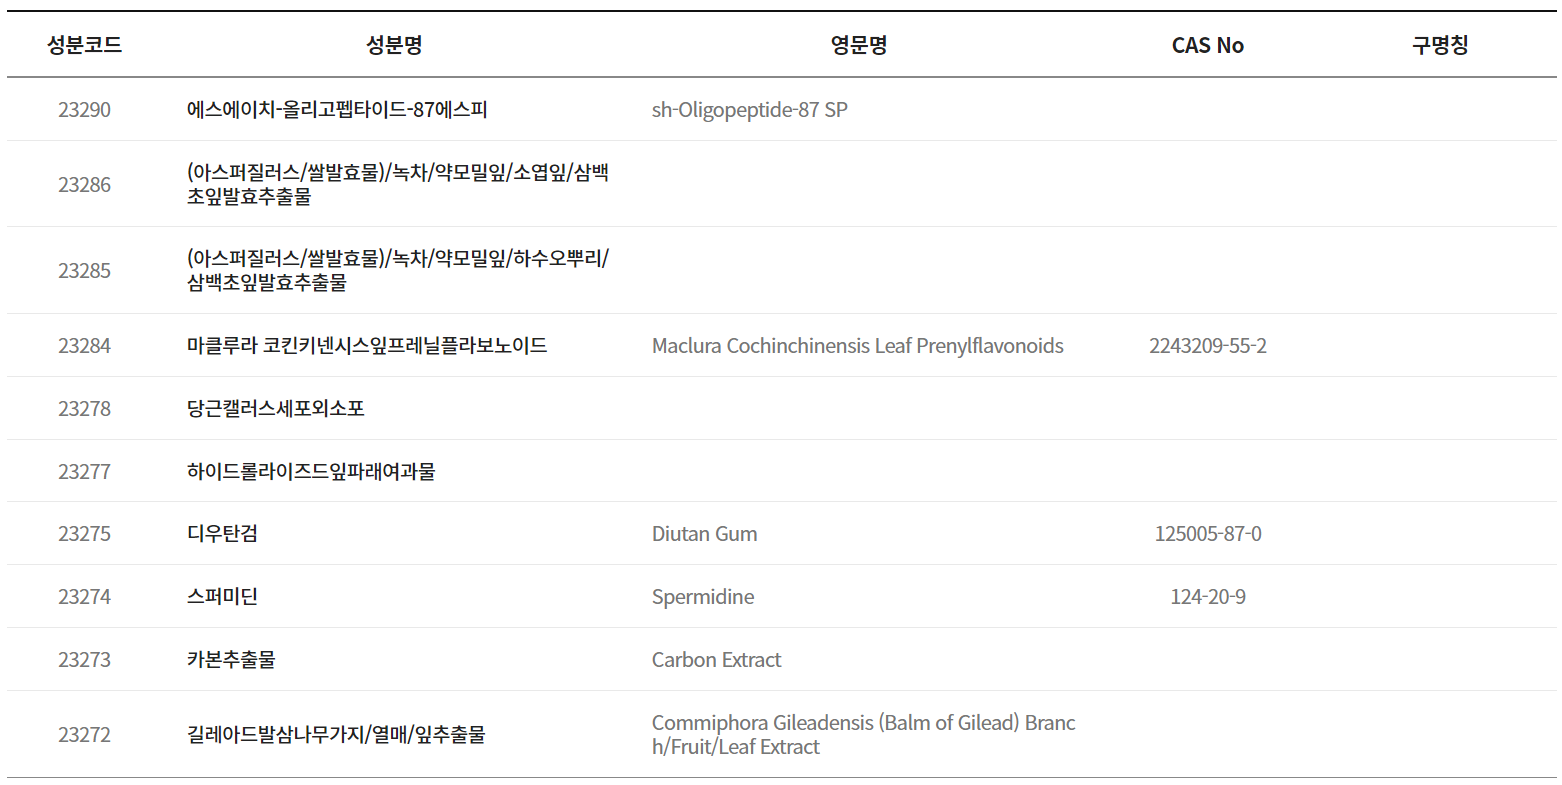

In [2]:
Image("./img/KCA_1.png")

In [3]:
# 테이블 기본 구조 만들기
cols = ['성분코드', '성분명', '영문명', 'CAS No', '구명칭']
kca_ing_name_df = pd.DataFrame(columns=cols)
kca_ing_name_df

,성분코드,성분명,영문명,CAS No,구명칭


### 3. 테이블 내 데이터 저장

우선적으로 크롤링하려는 웹 페이지에 접속.
<br>
성분사전 내 모든 데이터를 가져오기 위해서
<br>
마지막 페이지에 대한 정보를 가져온 후,
<br>
각 페이지를 조회하면서 성분 데이터를 수집.

In [4]:
url = "https://kcia.or.kr/cid/search/ingd_list.php"
response = requests.get(url)

html = response.text
soup = BeautifulSoup(html, 'html.parser')
# 전체 자료수
total = int(soup.find('b','green').text.replace(',','')) 
last_page = 0 

# 한 페이지당 10개씩 기재되었음
# 마지막 페이지를 조회하는 방식
if total % 10 != 0: 
    last_page = (total // 10) + 1
else:
    last_page = total // 10

In [6]:
# 총 페이지 수 고려
for num in tqdm.notebook.tqdm(range(1, last_page+1)):
    # 페이지 숫자만 바꿔가면서 정보 조회
    url = f"https://kcia.or.kr/cid/search/ingd_list.php?page={num}" 
    response = requests.get(url)

    # 정상적인 페이지 response를 받으면 BeautifulSoup 모듈을 통해서 페이지 조회
    if response.status_code == 200:
        html = response.text
        soup = BeautifulSoup(html, 'html.parser')

    # parser_functions의 make2d로 테이블 데이터 수집
    data = soup.find('table',{"class" : "bbs_list"}) 
    data = parser_functions.make2d(data)[1:]

    # 임시 데이터프레임 만들기 : 이어서 구성하기 위해서
    tmp_df = pd.DataFrame(data, columns=cols)
    # 위에 만들어 놓은 빈 데이터프레임이랑 concat 하는 식으로 누적시킨다
    kca_ing_name_df = pd.concat([kca_ing_name_df ,tmp_df]) 

kca_ing_name_df

  0%|          | 0/2042 [00:00<?, ?it/s]

,성분코드,성분명,영문명,CAS No,구명칭
0,23303,생강나무가지/잎추출물,,,
1,23302,생강나무가지/잎수,,,
2,23301,락토바실러스/(참당귀뿌리/병풀/더덕뿌리/감초뿌리/홍삼뿌리/쇠비름)추출물발효여과물,,,
3,23299,뱀딸기열매,,,
4,23298,하이드롤라이즈드사슴뿔추출물,Hydrolyzed Deer Antler Extract,,
...,...,...,...,...,...
1,5,류신,Leucine,328-39-2(DL-)\r\n61-90-5(L-),
2,4,루핀아미노산,Lupine Amino Acids,,
3,3,구멍쇠미역추출물,Agarum Cribrosum Extract,,
4,2,가지열매추출물,Solanum Melongena (Eggplant) Fruit Extract,84012-19-1,가지추출물


### 4. 데이터 정렬

프로젝트 진행에 필요하지 않은 CAS $^{2}$ No와 구명칭 칼럼을 삭제하고
<br>
성분코드 순서대로 정렬.
<br>
<br>
<br>
CAS $^{2}$ 번호 : Chemical Abstract Service Register Number의 약자로
<br>
화학구조나 조성이 확정된 화학물질에 부여된 고유 번호.
<br>
미국 화학회에서 운영하며, 모든 화학물질을 중복없이 찾을 수 있도록 도와주는 서비스.

In [7]:
kca_ing_name_df = kca_ing_name_df.astype({'성분코드':'int'})
kca_ing_name_df = kca_ing_name_df[['성분코드', '성분명', '영문명']].set_index('성분코드').sort_index()

In [8]:
kca_ing_name_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24656 entries, 1 to 23303
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   성분명     24656 non-null  object
 1   영문명     24656 non-null  object
dtypes: object(2)
memory usage: 577.9+ KB


In [9]:
# 인덱스 조정
kca_ing_name_df.reset_index(inplace=True)

In [10]:
kca_ing_name_df.head(10)

,성분코드,성분명,영문명
0,1,가공소금,
1,2,가지열매추출물,Solanum Melongena (Eggplant) Fruit Extract
2,3,구멍쇠미역추출물,Agarum Cribrosum Extract
3,4,루핀아미노산,Lupine Amino Acids
4,5,류신,Leucine
5,6,류코노스톡/무발효여과물,Leuconostoc/Radish Root Ferment Filtrate
6,7,백혈구추출물,Leukocyte Extract
7,8,리나칸투스 콤무니스추출물,Rhinacanthus Communis Extract
8,9,리날룰,Linalool
9,10,리날릴아세테이트,Linalyl Acetate


### 5. 성분 표기 변경

수집한 성분명을 통해서 이후 inci-decoder $^{3}$ 사이트에서
<br>
보유한 모든 화장품에 대한 정보를 조회하기 위해
<br>
성분의 영문명을 사이트 url을 통해 조회하기 적합한
<br>
형태로 바꿔주는 작업을 거침.
<br>
<br>
<br>
inci-decoder $^{3}$ : 주소는 'https://incidecoder.com/'.
<br> 
Decode skincare ingredients fast with our science-based but easy-to-understand explanations.
<br>
Analyze ingredient lists at a press of a button.

In [11]:
# inci-decoer에 성분을 검색할 때, format이 맞지 않는 표기명들이 있었다.
# 괄호와 그 안에 들어있는 내용을 제거하자
import re
pattern = r'\([^)]*\)'

for idx, row in kca_ing_name_df.iterrows():
    tmp = kca_ing_name_df.iloc[idx]['영문명']
    try:
        if '(' in tmp:
            txt = re.sub(pattern=pattern, repl='', string= tmp)
            txt = ' '.join(txt.split())
            kca_ing_name_df.iloc[idx,2] = txt
    except:
        pass

In [12]:
kca_ing_name_df.head(10)

,성분코드,성분명,영문명
0,1,가공소금,
1,2,가지열매추출물,Solanum Melongena Fruit Extract
2,3,구멍쇠미역추출물,Agarum Cribrosum Extract
3,4,루핀아미노산,Lupine Amino Acids
4,5,류신,Leucine
5,6,류코노스톡/무발효여과물,Leuconostoc/Radish Root Ferment Filtrate
6,7,백혈구추출물,Leukocyte Extract
7,8,리나칸투스 콤무니스추출물,Rhinacanthus Communis Extract
8,9,리날룰,Linalool
9,10,리날릴아세테이트,Linalyl Acetate


In [13]:
# inci-decoder에 검색가능한 format으로 변경하여 컬럼 추가
kca_ing_name_df['formatted_영문명'] = kca_ing_name_df['영문명'].str.lower().str.replace(" ","-") 

In [14]:
kca_ing_name_df.head(10)

,성분코드,성분명,영문명,formatted_영문명
0,1,가공소금,,
1,2,가지열매추출물,Solanum Melongena Fruit Extract,solanum-melongena-fruit-extract
2,3,구멍쇠미역추출물,Agarum Cribrosum Extract,agarum-cribrosum-extract
3,4,루핀아미노산,Lupine Amino Acids,lupine-amino-acids
4,5,류신,Leucine,leucine
5,6,류코노스톡/무발효여과물,Leuconostoc/Radish Root Ferment Filtrate,leuconostoc/radish-root-ferment-filtrate
6,7,백혈구추출물,Leukocyte Extract,leukocyte-extract
7,8,리나칸투스 콤무니스추출물,Rhinacanthus Communis Extract,rhinacanthus-communis-extract
8,9,리날룰,Linalool,linalool
9,10,리날릴아세테이트,Linalyl Acetate,linalyl-acetate


In [15]:
kca_ing_name_df.to_csv('kca_ing_name.csv')